# Node2Vec

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from gensim.models import Word2Vec

## 读取图结构

In [2]:
INPUT_PATH = "../data/karate.edgelist"

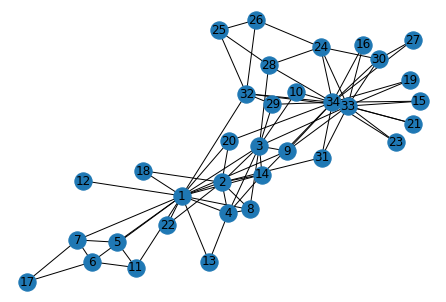

In [5]:
def read_graph():
    """
    从输入文件构建图
    """
    # 创建有向无权图 
    nx_graph = nx.read_edgelist(INPUT_PATH, nodetype=int, create_using=nx.DiGraph())
    # 设置边权重
    for edge in nx_graph.edges():
        nx_graph[edge[0]][edge[1]]["weight"] = 1
    # 将有向图转换为无向图
    nx_graph = nx_graph.to_undirected()
    return nx_graph

nx_graph = read_graph()
nx.draw(nx_graph, with_labels=True)
plt.show()

## 计算节点与边的 Alias Table

In [15]:
def alias_setup(normalized_probs):
    """
    Alias方法初始化
    """
    n = len(normalized_probs)
    probs = np.zeros(n)
    alias = np.zeros(n, dtype=np.int)
    
    # 将概率分成大于1与小于1的两组
    smaller, larger = [], []
    for i, p in enumerate(normalized_probs):
        probs[i] = p * n
        if probs[i] < 1.0:
            smaller.append(i)
        else:
            larger.append(i)
            
    # 使用贪心算法将概率小于1的不断填满
    while len(smaller) > 0 and len(larger) > 0:
        small = smaller.pop()
        large = larger.pop()
        
        alias[small] = large
        # 更新概率
        probs[large] = probs[large] - (1.0 - probs[small])
        if probs[large] < 1.0:
            smaller.append(large)
        else:
            larger.append(large)
            
    return probs, alias


def alias_draw(probs, alias):
    """
    Alias方法采样
    """
    n = len(probs)
    index = int(np.floor(np.random.rand() * n))
    if np.random.rand() < probs[index]:
        return index
    else:
        return alias[index]


class Graph:
    
    def __init__(self, nx_graph, p, q):
        self.nx_graph = nx_graph
        self.p = p
        self.q = q
        
    def get_alias_edge(self, u, v):
        """
        获取指定边的Alias初始化列表
        """
        unnormalized_probs = []
        # 论文算法
        for k in sorted(self.nx_graph.neighbors(v)):
            if k == u:
                unnormalized_probs.append(self.nx_graph[v][k]["weight"] / self.p)
            elif self.nx_graph.has_edge(k, u):
                unnormalized_probs.append(self.nx_graph[v][k]["weight"])
            else:
                unnormalized_probs.append(self.nx_graph[v][k]["weight"] / self.q)
        
        # 归一化
        norm_const = sum(unnormalized_probs)
        normalized_probs = [p / norm_const for p in unnormalized_probs]
        
        return alias_setup(normalized_probs)
        
    def preprocess_transition_probs(self):
        """
        预处理转移概率
        """
        alias_nodes = {}
        # 节点概率和归一化
        for u in self.nx_graph.nodes():
            unnormalized_probs = [self.nx_graph[u][v]["weight"] for v in sorted(self.nx_graph.neighbors(u))]
            norm_const = sum(unnormalized_probs)
            normalized_probs = [p / norm_const for p in unnormalized_probs]
            alias_nodes[u] = alias_setup(normalized_probs)
            
            # 输出展示信息
            if u == 2:
                print("node 2 unnormalized_probs:", unnormalized_probs)
                print("node 2 norm_const:", norm_const)
                print("node 2 normalized_probs:", normalized_probs)
                print("node 2 alias_node:", alias_nodes[u])
                
        alias_edges = {}
        for e in self.nx_graph.edges():
            alias_edges[(e[0], e[1])] = self.get_alias_edge(e[0], e[1])
            alias_edges[(e[1], e[0])] = self.get_alias_edge(e[1], e[0])
        print("edge 2->3 alias_edge:", alias_edges[(2, 3)])
        
        self.alias_nodes = alias_nodes
        self.alias_edges = alias_edges
            

In [18]:
graph = Graph(nx_graph, p=1, q=1)
graph.preprocess_transition_probs()

node 2 unnormalized_probs: [1, 1, 1, 1, 1, 1, 1, 1, 1]
node 2 norm_const: 9
node 2 normalized_probs: [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111]
node 2 alias_node: (array([1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([0, 0, 0, 0, 0, 0, 0, 0, 0]))
edge 2->3 alias_edge: (array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))


## 生成节点序列